In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Carregamento de Dados

In [3]:
df_receita = pd.read_csv('./datasets/sales_data.csv')

In [4]:
df_receita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tempo_de_experiencia  100 non-null    int64  
 1   numero_de_vendas      100 non-null    int64  
 2   fator_sazonal         100 non-null    int64  
 3   receita_em_reais      100 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 3.3 KB


In [5]:
df_receita_eda = df_receita.copy()

### Exploração dos Dados

In [6]:
df_receita_eda.head(10)

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
0,36,21,5,2639.886941
1,74,44,10,4707.322227
2,38,44,4,5910.035131
3,52,62,6,6130.742546
4,97,56,2,7516.457681
5,67,70,10,1247.882324
6,119,69,2,3485.606208
7,66,62,2,2773.987427
8,68,96,3,4177.919578
9,106,42,2,4719.691069


In [7]:
df_receita_eda.describe()

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
count,100.000000,100.000000,100.000000,100.000000
mean,64.490000,54.490000,5.820000,5112.941924
std,32.397935,25.307201,2.836914,2544.731052
min,1.000000,10.000000,1.000000,1133.363948
25%,38.750000,37.500000,4.000000,2800.660516
50%,64.500000,52.500000,5.000000,4953.770034
75%,93.000000,70.500000,8.000000,7079.500163
max,119.000000,100.000000,10.000000,9941.016458


In [8]:
df_receita_eda.isna().sum()

tempo_de_experiencia    0
numero_de_vendas        0
fator_sazonal           0
receita_em_reais        0
dtype: int64

<Axes: xlabel='tempo_de_experiencia'>

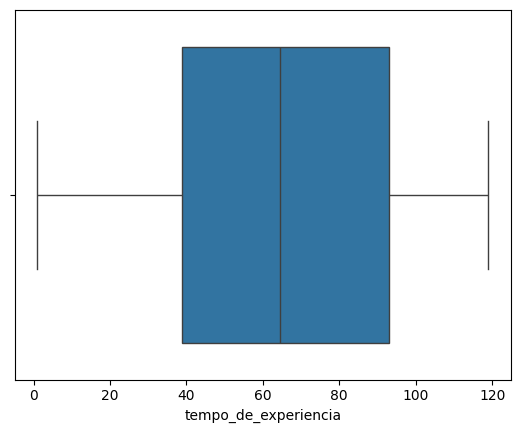

In [9]:
sns.boxplot(data=df_receita_eda, x='tempo_de_experiencia')

<Axes: xlabel='numero_de_vendas'>

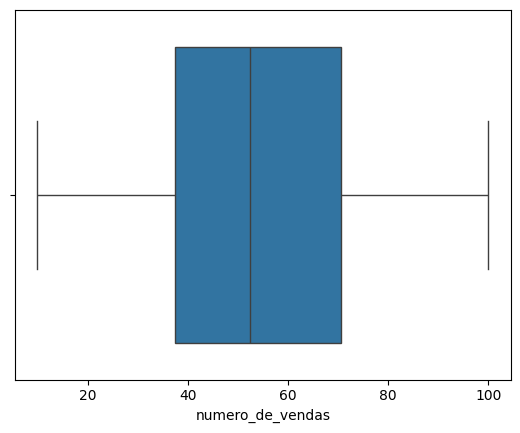

In [10]:
sns.boxplot(data=df_receita_eda, x='numero_de_vendas')

<Axes: xlabel='fator_sazonal'>

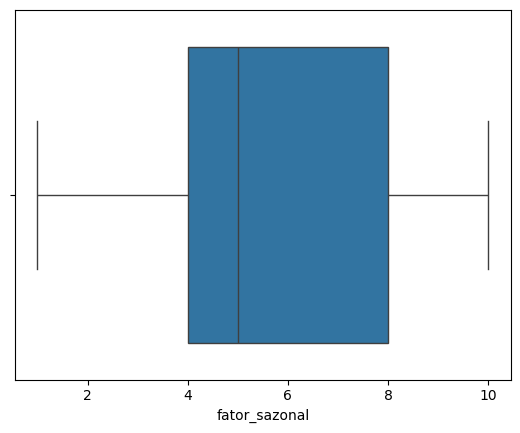

In [11]:
sns.boxplot(data=df_receita_eda, x='fator_sazonal')

<Axes: xlabel='receita_em_reais'>

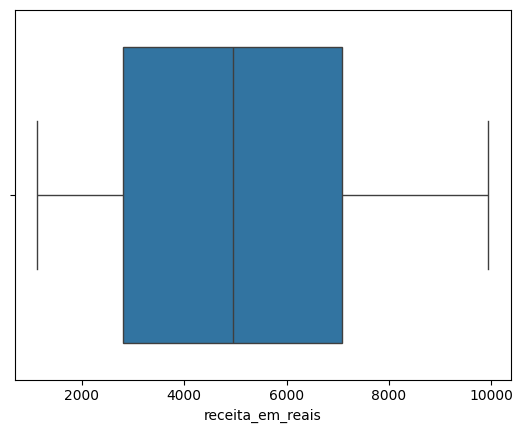

In [12]:
sns.boxplot(data=df_receita_eda, x='receita_em_reais')

<Axes: xlabel='tempo_de_experiencia', ylabel='receita_em_reais'>

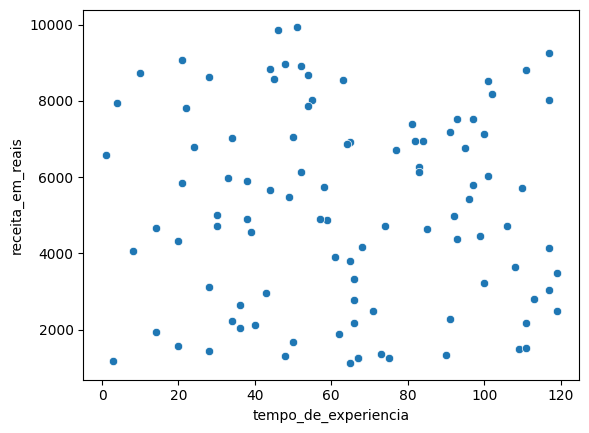

In [13]:
sns.scatterplot(data=df_receita_eda, x='tempo_de_experiencia', y='receita_em_reais')

<Axes: xlabel='numero_de_vendas', ylabel='receita_em_reais'>

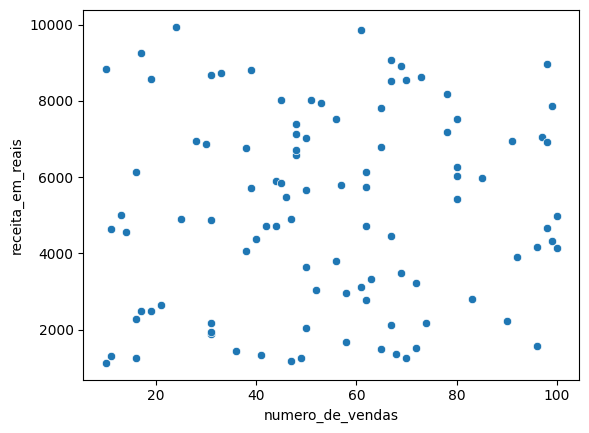

In [14]:
sns.scatterplot(data=df_receita_eda, x='numero_de_vendas', y='receita_em_reais')

<Axes: xlabel='fator_sazonal', ylabel='receita_em_reais'>

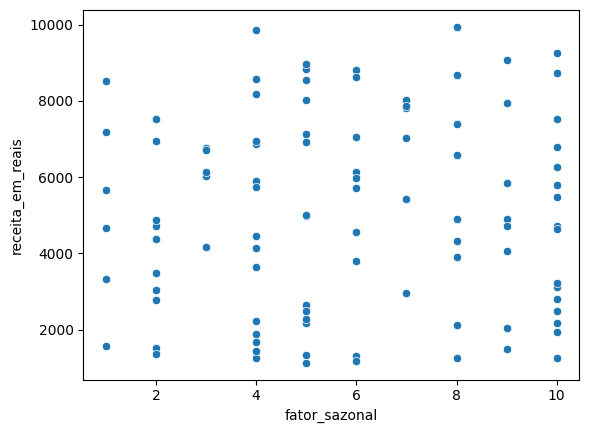

In [15]:
sns.scatterplot(data=df_receita_eda, x='fator_sazonal', y='receita_em_reais')

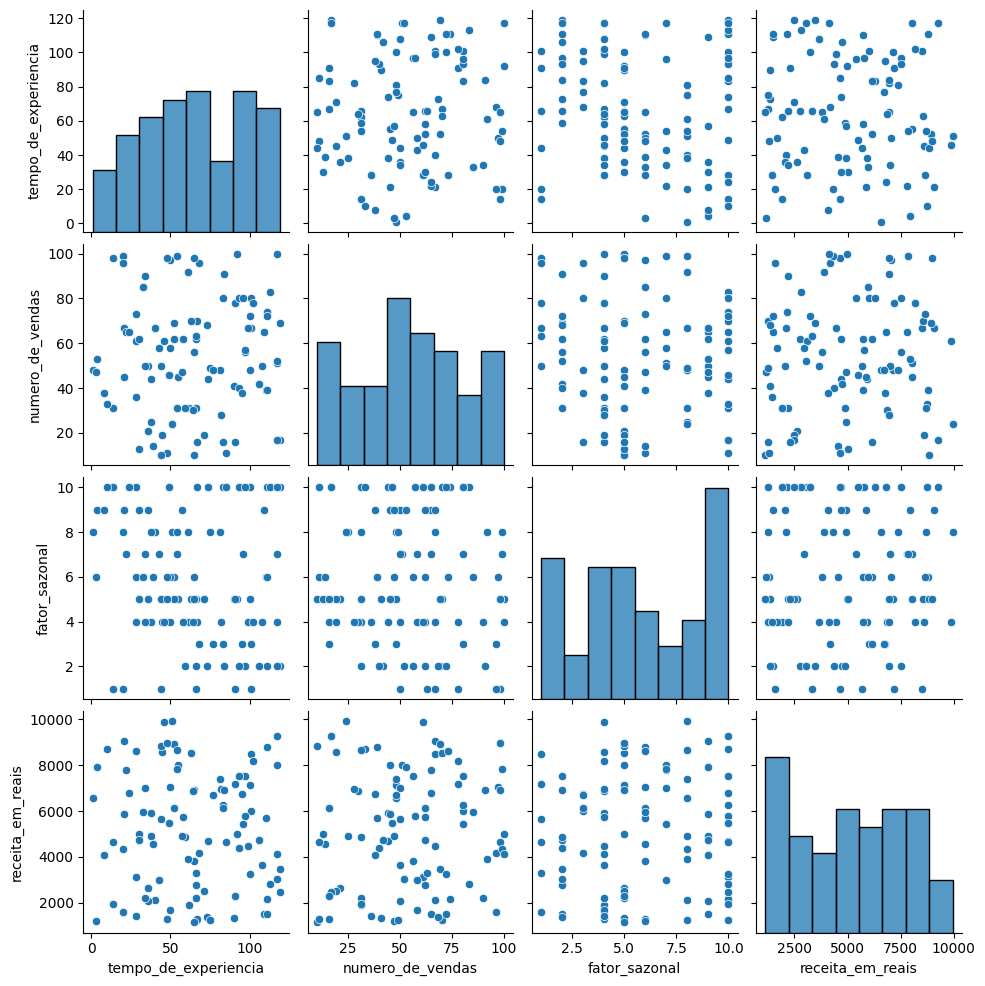

In [16]:
sns.pairplot(df_receita_eda)

<Axes: >

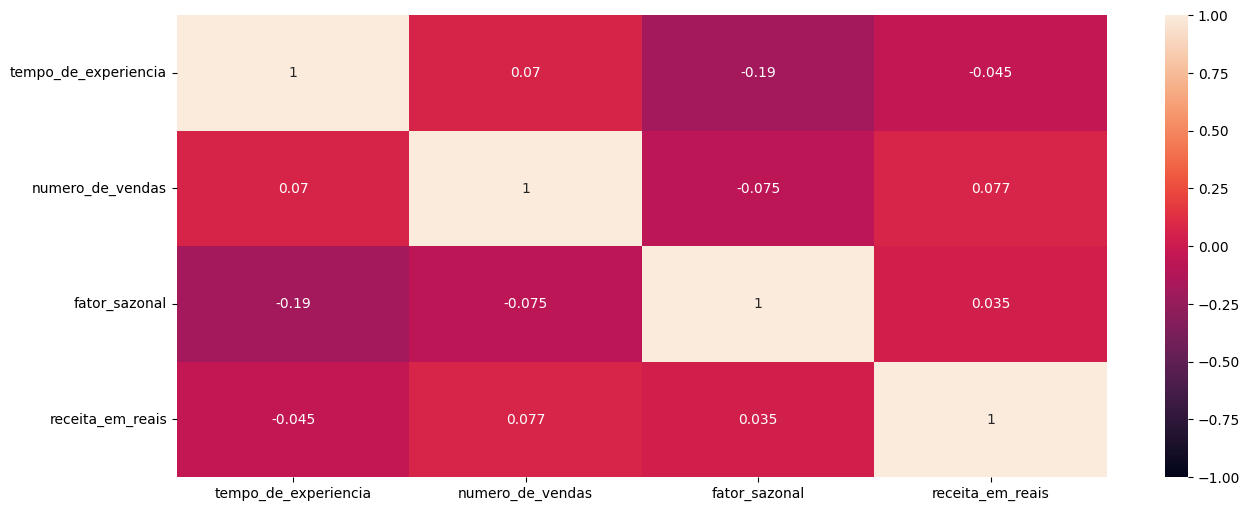

In [17]:
plt.figure(figsize=(15,6))
sns.heatmap(df_receita_eda.corr('spearman',), vmin=-1, vmax=1, annot=True)

<Axes: >

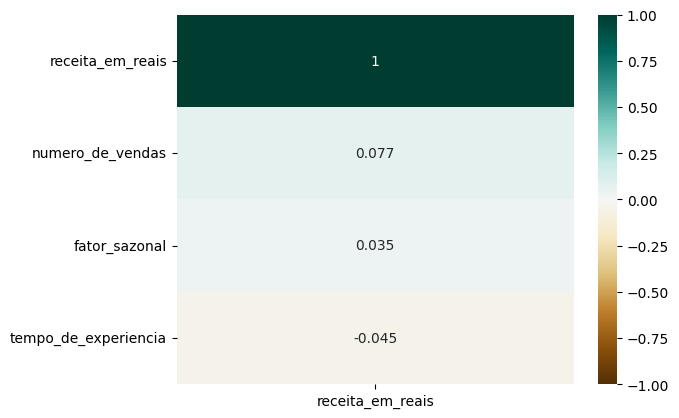

In [18]:
sns.heatmap(df_receita_eda.corr('spearman')[['receita_em_reais']].sort_values(by='receita_em_reais', ascending=False), vmin=-1,vmax=1,annot=True, cmap='BrBG')

### Treinar Modelo Linear

In [19]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error

import numpy as np

In [20]:
X = df_receita.drop(columns='receita_em_reais', axis=1)
y = df_receita['receita_em_reais']

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [22]:
kf.split(X)

<generator object _BaseKFold.split at 0x000002BDE8451F10>

In [23]:
colunas_numericas = ['tempo_de_experiencia', 'numero_de_vendas', 'fator_sazonal']

tranformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', tranformer_numericas, colunas_numericas)
    ]
)

model_reg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

rmse_scores_fold_train = []
rmse_scores_fold_test = []

r2score_fold_test = []

residuos = []

mse_fold_test = []

y_pred_total = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_reg.fit(X_train, y_train)

    y_train_pred = model_reg.predict(X_train)
    y_test_pred = model_reg.predict(X_test)

    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    mse_fold_test.append(mse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)

rmse_train_final = np.mean(rmse_scores_fold_train)    
rmse_test_final = np.mean(rmse_scores_fold_test)
mse_test_final = np.mean(mse_fold_test)   
r2score_test_final = np.mean(r2score_fold_test)
percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)




### Análise de Métricas - Modelo Linear

In [24]:

print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')
print(f'MSE: {mse_test_final}')

RMSE Treino: 2503.7778480738625
RMSE Teste: 2657.652017969138
% Dif. RMSE Treino e Teste: 6.1456798179458945
R2Score Teste: -0.1444571756461522
MSE: 7111556.44204195


### Análise de Resíduos - Modelo Linear

In [25]:
from scipy.stats import zscore
residuos_std = zscore(residuos)

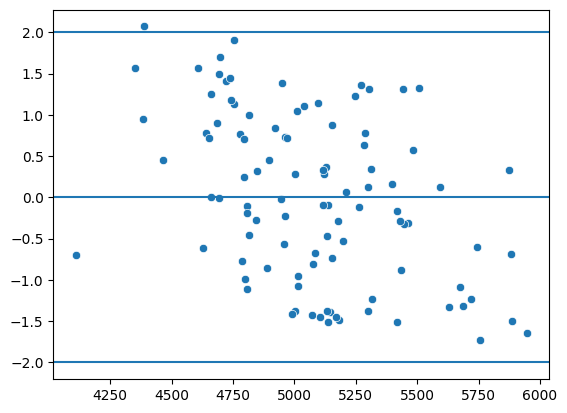

In [26]:
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

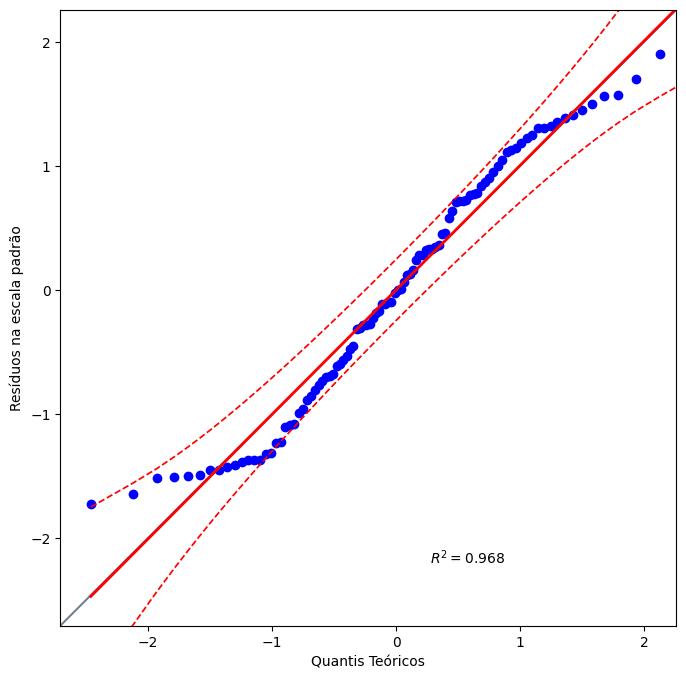

In [27]:
import pingouin as pg
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [28]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste {stat_shapiro} e P-Value {p_value_shapiro}')

Estat. Teste 0.9603400453291031 e P-Value 0.004252356300943491


In [29]:
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste {stat_ks} e P-Value {p_value_ks}')

Estat. Teste 0.5 e P-Value 1.213143437181786e-23


In [30]:
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste {stat_ll} e P-Value {p_value_ll}')

Estat. Teste 0.0787194047136276 e P-Value 0.1409104092052727


### Treinar Modelo Polinomial

In [57]:
graus_polynomial = [2]

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
    colunas_numericas = ['tempo_de_experiencia', 'numero_de_vendas', 'fator_sazonal']

    tranformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', tranformer_numericas, colunas_numericas)
        ]
    )

    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    model_poly = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('poly_features', poly_feat),
                                 ('regressor', LinearRegression())])
    
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    r2score_fold_test = []

    residuos = []

    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_poly.fit(X_train, y_train)

        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)

        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        mse_fold_test.append(mse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)

    rmse_train_final = np.mean(rmse_scores_fold_train)    
    rmse_test_final = np.mean(rmse_scores_fold_test)
    mse_test_final = np.mean(mse_fold_test)   
    r2score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2score_test_final)
    percentual_rmse_values.append(percentual_rmse_final)


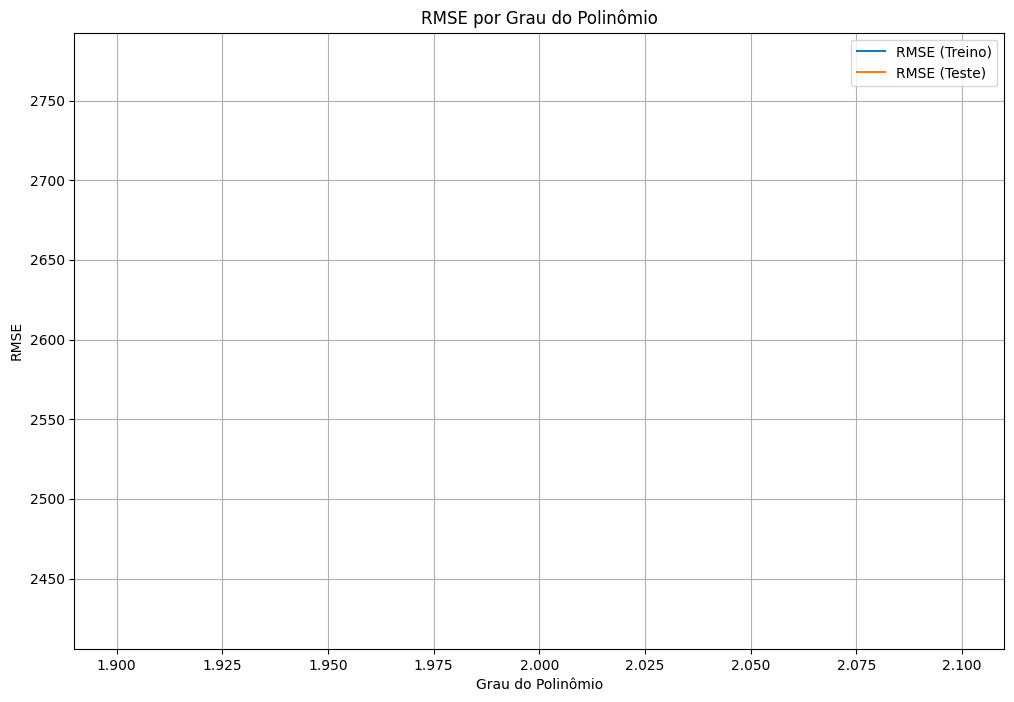

In [58]:
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, rmse_train_values, label='RMSE (Treino)')
plt.plot(graus_polynomial, rmse_test_values, label='RMSE (Teste)')
plt.xlabel('Grau do Polinômio')
plt.ylabel('RMSE')
plt.title('RMSE por Grau do Polinômio')
plt.legend()
plt.grid(True)
plt.show()

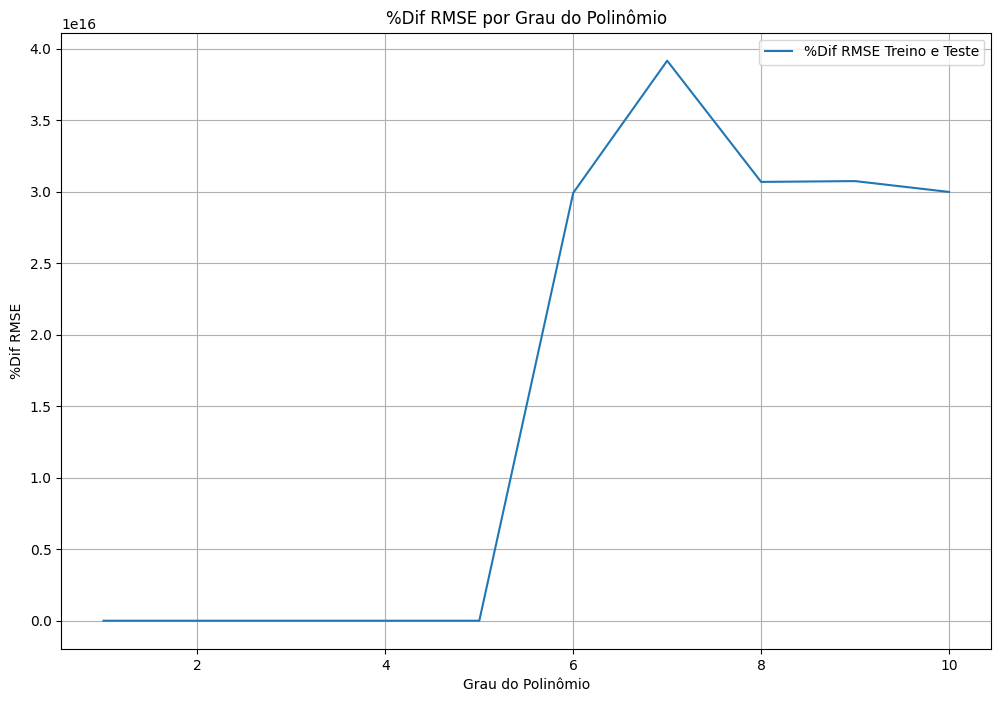

In [33]:
plt.figure(figsize=(12,8))
plt.plot(graus_polynomial, percentual_rmse_values, label='%Dif RMSE Treino e Teste')
plt.xlabel('Grau do Polinômio')
plt.ylabel('%Dif RMSE')
plt.title('%Dif RMSE por Grau do Polinômio')
plt.legend()
plt.grid(True)
plt.show()

### Análise de Métricas - Modelo Polinomial

In [59]:
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')
print(f'MSE: {mse_test_final}')

RMSE Treino: 2423.5170534288945
RMSE Teste: 2775.008357109534
% Dif. RMSE Treino e Teste: 14.503355905143497
R2Score Teste: -0.2466649072431138
MSE: 34911191728.98998


In [60]:
from scipy.stats import zscore
residuos_std = zscore(residuos)

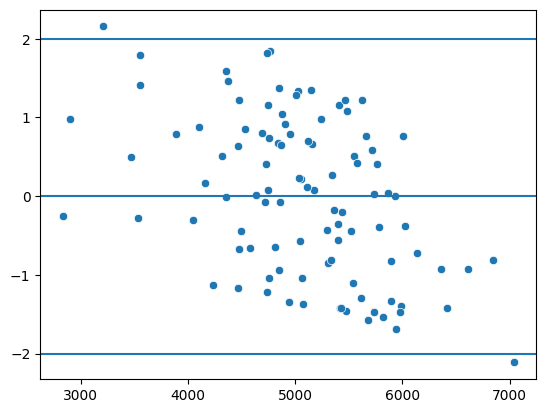

In [61]:
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

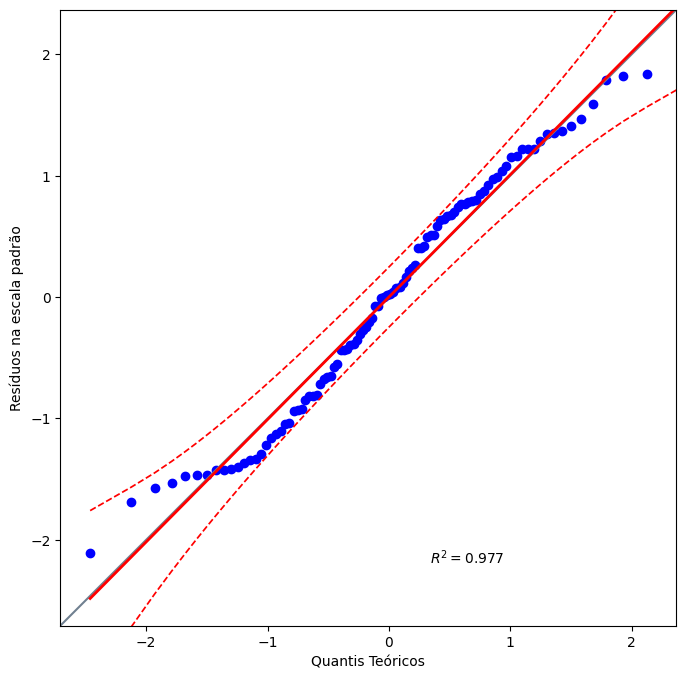

In [62]:
import pingouin as pg
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [63]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste {stat_shapiro} e P-Value {p_value_shapiro}')

Estat. Teste 0.9719685335705001 e P-Value 0.03133396932539388


In [ ]:

stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste {stat_ks} e P-Value {p_value_ks}')


Estat. Teste 0.53 e P-Value 9.783646983229687e-27


In [ ]:

stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste {stat_ll} e P-Value {p_value_ll}')


Estat. Teste 0.07546356887253924 e P-Value 0.18511179596819533


In [70]:
input_features = {
    'tempo_de_experiencia': 50,
    'numero_de_vendas': 11,
    'fator_sazonal': 5
}

pred_df = pd.DataFrame(input_features, index=[1])

In [71]:
model_poly.predict(pred_df)

array([4599.63391805])

In [72]:
import joblib

In [73]:
joblib.dump(model_poly, './modelo_receita.pkl')

['./modelo_receita.pkl']